## Particle aggregation

### Imports

In [45]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("GLMakie")

# Enabling packages
using CellBasedModels
using GLMakie

Makie.inline!(true);

   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`


### Code

#### Construct the AgentBasedModel (ABM)

In [46]:
model = ABM(2,

    #In the keyword argument agent we declare all the agent arguments and its scope
    agent = Dict(
        :fx => Float64,
        :fy => Float64,
        ),

    #In the keyword argument model we declare all the model arguments and its scope
    model = Dict(
        :rRep => Float64,
        :fRep => Float64,
        :rAtr => Float64,
        :fAtr => Float64,
        :D => Float64
        ),

    # In here we define the ODE part
    agentODE = quote
        # Compute adhesion and repulsion forces
            # Reset the parameters to zero zero
        fx = 0
        fy = 0
            # Go over the neighbors and add the forces, for that we use the macro @loopOverNeighbors
        @loopOverNeighbors i2 begin
            d = CBMMetrics.euclidean(x,x[i2],y,y[i2])
            dirx = (x-x[i2])/d
            diry = (y-y[i2])/d
            if d < rRep # Repulsion forces
                fx += fRep*(rRep-d)*dirx
                fy += fRep*(rRep-d)*diry
            elseif d < rAtr # Attraction forces
                fx += -fAtr*(rAtr-d)*dirx
                fy += -fAtr*(rAtr-d)*diry
            end
        end
            # Add the forces comming from the boundary interaction
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]/2
            fy -= fRep
        end
    
        # Finally, define the deterministic terms of the SDE
        dt(x) = fx
        dt(y) = fy
    end,

    # In here we define the SDE part
    agentSDE = quote
        # SDE term
        dt(x) = D
        dt(y) = D 
    end
);

#### Tests

##### Test repulsion from other agents

In [47]:
simBox = [-5. 5; -2 2]
#Initialize community
com = Community(model,
        N=2,
        dt=.1,
        simBox = simBox
        );

#Setup user paramaters
        #Constants
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
        #Agent parameters
com.x=[-.1,.1]
com.y=[0.,0.];
# If we do not define fx and fy, they are initialy set to zeros

2-element Vector{Float64}:
 0.0
 0.0

In [48]:
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => Any[]
  :y  => Any[]
  :fx => Any[]
  :t  => Any[]
  :x  => Any[]

##### Test repulsion from the boundaries

In [49]:
simBox = [-2. 2; -2 2]
#Initialize community
com = Community(model,
        N=1,
        dt=.1,
        simBox = simBox,
        );

#Setup user paramaters
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.x=[0]
com.y=[-2.5];

In [50]:
#Get parameters
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => Any[]
  :y  => Any[]
  :fx => Any[]
  :t  => Any[]
  :x  => Any[]

#### Constructing over a predefined model

In [51]:
model2 = ABM(2,

    #Import the previous model
    baseModelInit = [model],

    #Add an additional model parameter that defines the speed of the diffusion parameter decay
    model = Dict(
        :αT => Float64
    ),

    #Add a ODE to describe the difussion
    modelODE = quote
        dt(D) = -αT*D
    end,

    agentAlg = CBMIntegrators.EM(),
    modelAlg = DifferentialEquations.Euler(),
    neighborsAlg = CBMNeighbors.CellLinked(cellEdge=2),
);

In [52]:
simBox = [-10. 10; -10 10]
N = 100
com = Community(model2,
        N=N,
        dt=0.1,
        simBox = simBox,
        )

com.rRep=.8
com.fRep=1
com.rAtr=1
com.fAtr=1
com.αT=.001 
com.x = 20 .*rand(N) .-10
com.y = 20 .*rand(N) .-10
com.D=.15

0.15

In [53]:
evolve!(com,steps=8000,saveEach=1)

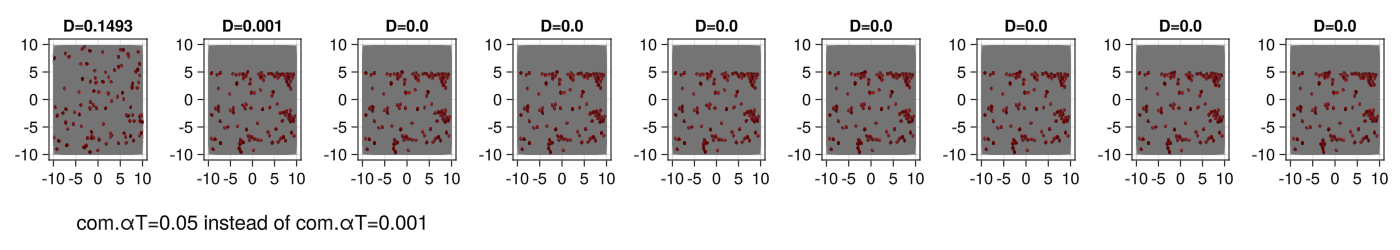

In [54]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(1400,250))

for (pos,i) in enumerate(1:999:8000)
    ax = Axis(fig[1,pos],title="D=$(round(com[i].D[1],digits=4))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.0),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,
                color=[com[i].D[1] for i in 1:100],
                colorrange=(0.,0.15),
                colormap=:reds
                )
    xlims!(ax,(simBox[1,:].+[-1,1])...)
    ylims!(ax,(simBox[2,:].+[-1,1])...)
    # lines!(ax,[i[1] for i in d[:x]],[i[1] for i in d[:y]])
end

# save("agg.png",fig)

Label(fig[2, 1:3], "com.αT=0.05 instead of com.αT=0.001", fontsize = 20, halign = :center)
display(fig)
save("D:/JuliaProjects/CellBasedModelsF1/results/testing/particle_aggregation_repulsion_diffusion_testing_9.png", fig)